In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Partition data into subsessions

In [ ]:
def partition_into_subsessions(df, id_columns=['user', 'subject', 'session', 'build']):
    """
    Partition data into 10 sequential subsessions for each participant.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the feature vectors.
    id_columns : list, optional
        Columns that identify unique participants/sessions.

    Returns:
    --------
    pandas.DataFrame
        The original dataframe with an additional 'subsession' column.
    """
    # Create a copy of the dataframe to avoid modifying the original
    result_df = df.copy()

    # Add a subsession column initialized with NaN
    result_df['subsession'] = np.nan

    # Group by the identifying columns that define a unique participant session
    for group_keys, group_df in df.groupby(id_columns):
        # Get the indices of this group
        indices = group_df.index

        # Calculate the size of each subsession (approximately equal parts)
        subsession_size = len(indices) // 10
        remainder = len(indices) % 10

        # Assign subsession numbers (1-10) to each row
        for i in range(10):
            # Calculate the start and end indices for this subsession
            # Distribute the remainder across the first 'remainder' subsessions
            start_idx = i * subsession_size + min(i, remainder)
            end_idx = (i + 1) * subsession_size + min(i + 1, remainder)

            # Extract the indices for this subsession
            subsession_indices = indices[start_idx:end_idx]

            # Assign the subsession number (1-indexed)
            result_df.loc[subsession_indices, 'subsession'] = i + 1

    # Convert subsession to integer type
    result_df['subsession'] = result_df['subsession'].astype(int)

    return result_df



In [ ]:
# Example usage:
df = pd.read_csv('/content/drive/MyDrive/SSIL/Researh Paper analysis /DataSets/processed_dataset(90-Features).csv')
df_with_subsessions = partition_into_subsessions(df)
df_with_subsessions.subsession.unique(), df_with_subsessions.shape

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), (19191, 95))

In [ ]:
# Check the exact string representation of your session values
print([f"{x}|{type(x)}" for x in df_with_subsessions['session'].unique()])

# Try a more robust mapping approach
df_with_subsessions['session'] = df_with_subsessions['session'].astype(str)
session_mapping = {'ses-A': 'learning', 'ses-B': 'retention'}
df_with_subsessions['session'] = df_with_subsessions['session'].replace(session_mapping)

# Verify the mapping worked
print(df_with_subsessions['session'].unique())

["ses-A|<class 'str'>", "ses-B|<class 'str'>"]
['learning' 'retention']


## Train and evaluate a single classifier using Monte Carlo leave-one-out cross-validation

In [ ]:


def run_single_classifier_experiment(df, feature_columns, classifier_type, id_column='user',
                                     subsession_column='subsession', n_monte_carlo=20,
                                     session_type=None, session_column='session'):
    """
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing feature vectors and subsession partitions
    feature_columns : list
        List of column names to use as features
    classifier_type : str
        Type of classifier to use ('knn', 'rf', or 'gbm')
    id_column : str
        Column name that identifies participants
    subsession_column : str
        Column name that identifies subsessions (1-10)
    n_monte_carlo : int
        Number of Monte Carlo trials for cross-validation
    session_type : str or None
        If provided, filter data to only include this session type
    session_column : str
        Column name that identifies session type

    Returns:
    --------
    dict
        Dictionary with classifier accuracy results
    """
    # Results storage
    results = {
        'accuracies': [],
        'predictions': []
    }

    # Filter data if session_type is provided
    if session_type is not None:
        df = df[df[session_column] == session_type].copy()
        if df.empty:
            raise ValueError(f"No data found for session_type={session_type}")

    # Store unique participants
    participants = df[id_column].unique()

    # Run Monte Carlo cross-validation
    for mc_iter in range(n_monte_carlo):
        print(f"Monte Carlo iteration {mc_iter+1}/{n_monte_carlo} for {classifier_type}")

        # For each participant, select one subsession for testing ( randomly)
        test_indices = []
        train_indices = []

        for participant in participants:
            participant_data = df[df[id_column] == participant]
            subsessions = participant_data[subsession_column].unique()

            # select one subsession for testing ( randomly )
            test_subsession = random.choice(subsessions)

            # Store index for test and train sets
            participant_test_indices = participant_data[participant_data[subsession_column] == test_subsession].index
            participant_train_indices = participant_data[participant_data[subsession_column] != test_subsession].index

            test_indices.extend(participant_test_indices)
            train_indices.extend(participant_train_indices)

        # Split features and labels
        X_train = df.loc[train_indices, feature_columns].values
        y_train = df.loc[train_indices, id_column].values
        X_test = df.loc[test_indices, feature_columns].values
        y_test = df.loc[test_indices, id_column].values
        test_subsessions = df.loc[test_indices, subsession_column].values
        test_participants = df.loc[test_indices, id_column].values

        # Create Target-subsession pairs for test data
        test_pairs = [(test_participants[i], test_subsessions[i]) for i in range(len(test_participants))]
        unique_test_pairs = list(set(test_pairs))

        if classifier_type == 'knn':
            # Normalize data for kNN
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            classifier = KNeighborsClassifier(n_neighbors=5)
            classifier.fit(X_train_scaled, y_train)
            preds = classifier.predict(X_test_scaled)
        elif classifier_type == 'rf':
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
            classifier.fit(X_train, y_train)
            preds = classifier.predict(X_test)
        elif classifier_type == 'gbm':
            classifier = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=1, random_state=42)
            classifier.fit(X_train, y_train)
            preds = classifier.predict(X_test)
        else:
            raise ValueError(f"Unsupported classifier_type: {classifier_type}")

        subsession_preds = []
        true_subsession_labels = []

        for participant, subsession in unique_test_pairs:
            # index for this Target-subsession Pair
            indices = [i for i, (p, s) in enumerate(test_pairs) if p == participant and s == subsession]

            # true labels
            true_label = participant
            true_subsession_labels.append(true_label)

            # Predictions for this subsession
            subsession_pred = Counter([preds[i] for i in indices]).most_common(1)[0][0]
            subsession_preds.append(subsession_pred)

        # Calculate accuracy
        accuracy = accuracy_score(true_subsession_labels, subsession_preds)

        # Results
        results['accuracies'].append(accuracy)
        results['predictions'].append(subsession_preds)

    results['mean_accuracy'] = np.mean(results['accuracies'])
    results['std'] = np.std(results['accuracies'])
    results['min'] = np.min(results['accuracies'])
    results['max'] = np.max(results['accuracies'])

    return results

## # Classification Results for Learning and Retention Sessions

In [ ]:
# Run kNN classifier on ses-A (learning session)
knn_learning_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='knn',
    session_type='learning', session_column='session', n_monte_carlo=20  # Try with fewer iterations first
)

# Run Random Forest classifier on ses-A (learning session)
rf_learning_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='rf',
    session_type='learning', session_column='session', n_monte_carlo=20
)

# Run Gradient Boosting classifier on ses-A (learning session)
gbm_learning_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='gbm',
    session_type='learning', session_column='session', n_monte_carlo=1
)

# Print results for learning session
print("\nLearning Session (ses-A) Results:")
print(f"kNN Accuracy: {knn_learning_results['mean_accuracy']*100:.2f}%")
print(f"RF Accuracy: {rf_learning_results['mean_accuracy']*100:.2f}%")
print(f"GBM Accuracy: {gbm_learning_results['mean_accuracy']*100:.2f}%")

# Run the same for ses-B (retention session)
knn_retention_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='knn',
    session_type='retention', session_column='session', n_monte_carlo=20
)

rf_retention_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='rf',
    session_type='retention', session_column='session', n_monte_carlo=20
)

gbm_retention_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='gbm',
    session_type='retention', session_column='session', n_monte_carlo=1
)

# Print results for retention session
print("\nRetention Session (ses-B) Results:")
print(f"kNN Accuracy: {knn_retention_results['mean_accuracy']*100:.2f}%")
print(f"RF Accuracy: {rf_retention_results['mean_accuracy']*100:.2f}%")
print(f"GBM Accuracy: {gbm_retention_results['mean_accuracy']*100:.2f}%")

Monte Carlo iteration 1/20 for knn
Monte Carlo iteration 2/20 for knn
Monte Carlo iteration 3/20 for knn
Monte Carlo iteration 4/20 for knn
Monte Carlo iteration 5/20 for knn
Monte Carlo iteration 6/20 for knn
Monte Carlo iteration 7/20 for knn
Monte Carlo iteration 8/20 for knn
Monte Carlo iteration 9/20 for knn
Monte Carlo iteration 10/20 for knn
Monte Carlo iteration 11/20 for knn
Monte Carlo iteration 12/20 for knn
Monte Carlo iteration 13/20 for knn
Monte Carlo iteration 14/20 for knn
Monte Carlo iteration 15/20 for knn
Monte Carlo iteration 16/20 for knn
Monte Carlo iteration 17/20 for knn
Monte Carlo iteration 18/20 for knn
Monte Carlo iteration 19/20 for knn
Monte Carlo iteration 20/20 for knn
Monte Carlo iteration 1/20 for rf
Monte Carlo iteration 2/20 for rf
Monte Carlo iteration 3/20 for rf
Monte Carlo iteration 4/20 for rf
Monte Carlo iteration 5/20 for rf
Monte Carlo iteration 6/20 for rf
Monte Carlo iteration 7/20 for rf
Monte Carlo iteration 8/20 for rf
Monte Carlo itera

## Classifier Accuracy Comparison for Learning and Retention Sessions

This visualization compares the accuracy of three classifiers—k-Nearest Neighbors (kNN), Random Forest (RF), and Gradient Boosting (GBM) across two sessions:
- **Learning Session (ses-A)**
- **Retention Session (ses-B)**

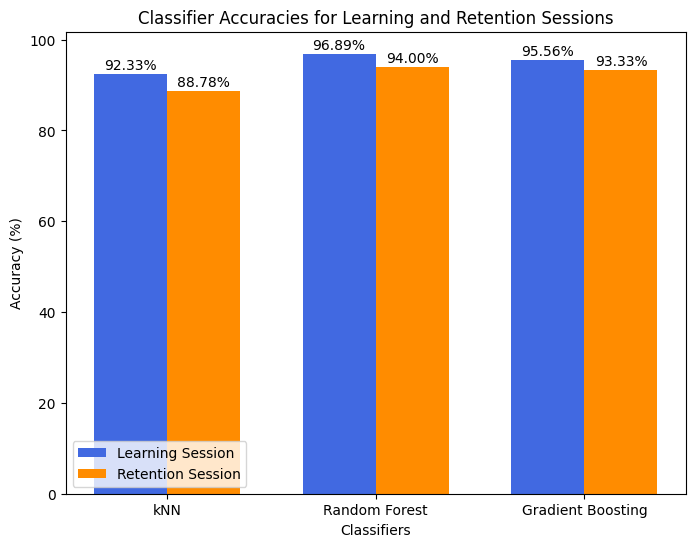

In [ ]:
# Define classifier names and their corresponding mean accuracies for learning and retention sessions
classifiers = ['kNN', 'Random Forest', 'Gradient Boosting']
learning_accuracies = [
    knn_learning_results['mean_accuracy'] * 100,
    rf_learning_results['mean_accuracy'] * 100,
    gbm_learning_results['mean_accuracy'] * 100
]
retention_accuracies = [
    knn_retention_results['mean_accuracy'] * 100,
    rf_retention_results['mean_accuracy'] * 100,
    gbm_retention_results['mean_accuracy'] * 100
]

# Set bar width and positions
bar_width = 0.35
x = np.arange(len(classifiers))

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - bar_width/2, learning_accuracies, bar_width, label='Learning Session', color='royalblue')
ax.bar(x + bar_width/2, retention_accuracies, bar_width, label='Retention Session', color='darkorange')

# Labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Classifier Accuracies for Learning and Retention Sessions')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()

# Show values on top of bars
for i in range(len(classifiers)):
    ax.text(x[i] - bar_width/2, learning_accuracies[i] + 1, f"{learning_accuracies[i]:.2f}%", ha='center', fontsize=10)
    ax.text(x[i] + bar_width/2, retention_accuracies[i] + 1, f"{retention_accuracies[i]:.2f}%", ha='center', fontsize=10)

# Show plot
plt.show()

## Performance Comparison: Random Forest (RF) vs. kNN

This experiment evaluates the performance of **Random Forest (RF)** and **k-Nearest Neighbors (kNN)** classifiers by:
- Training on the **Learning Session (ses-A)**
- Testing on the **Retention Session (ses-B)**
- Measuring the accuracy drop between sessions
- Monte Carlo Iteration = 1

In this experiment below, **Monte Carlo Iteration = 1** means that each classifier is trained and tested only once per session. This provides a **single-run estimate** of model performance without averaging over multiple random splits of the data.

In [ ]:
# Train Random Forest (RF) on learning session (ses-A)
rf_learning_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='rf',
    session_type='learning', session_column='session', n_monte_carlo=1
)

# Train kNN on learning session (ses-A)
knn_learning_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='knn',
    session_type='learning', session_column='session', n_monte_carlo=1
)

# Test Random Forest (RF) on retention session (ses-B)
rf_retention_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='rf',
    session_type='retention', session_column='session', n_monte_carlo=1
)

# Test kNN on retention session (ses-B)
knn_retention_results = run_single_classifier_experiment(
    df_with_subsessions, feature_columns, classifier_type='knn',
    session_type='retention', session_column='session', n_monte_carlo=1
)

# Print performance comparison for RF and kNN
print("\nPerformance Comparison for RF and kNN:")
print(f"Random Forest Accuracy Drop (Learning to Retention): {100*(rf_learning_results['mean_accuracy'] - rf_retention_results['mean_accuracy']):.2f}%")
print(f"kNN Accuracy Drop (Learning to Retention): {100*(knn_learning_results['mean_accuracy'] - knn_retention_results['mean_accuracy']):.2f}%")

Monte Carlo iteration 1/1 for rf
Monte Carlo iteration 1/1 for knn
Monte Carlo iteration 1/1 for rf
Monte Carlo iteration 1/1 for knn

Performance Comparison for RF and kNN:
Random Forest Accuracy Drop (Learning to Retention): 4.44%
kNN Accuracy Drop (Learning to Retention): 2.22%


## Monte Carlo Leave-One-Out Cross-Validation for Classifiers

### Function: `run_single_classifier_experiment_test`

- This function trains and evaluates a classifier using **Monte Carlo leave-one-out cross-validation**.  
- It supports **KNN, Random Forest, and Gradient Boosting** classifiers.
- Here we state traning and testing session in the arguments.

In [ ]:
def run_single_classifier_experiment_test(df, feature_columns, classifier_type, id_column='user',
                                     subsession_column='subsession', n_monte_carlo=20,
                                     session_type=None, session_column='session',
                                     training_session=None, testing_session=None):
    """
    Train and evaluate a single classifier using Monte Carlo leave-one-out cross-validation.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing feature vectors and subsession partitions
    feature_columns : list
        List of column names to use as features
    classifier_type : str
        Type of classifier to use ('knn', 'rf', or 'gbm')
    id_column : str
        Column name that identifies participants
    subsession_column : str
        Column name that identifies subsessions (1-10)
    n_monte_carlo : int
        Number of Monte Carlo trials for cross-validation
    session_type : str or None
        If provided, filter data to only include this session type
    session_column : str
        Column name that identifies session type
    training_session : str or None
        The session type used for training (e.g., 'learning', 'retention')
    testing_session : str or None
        The session type used for testing (e.g., 'learning', 'retention')

    Returns:
    --------
    dict
        Dictionary with classifier accuracy results
    """
    # Initialize results storage
    results = {
        'accuracies': [],
        'predictions': []
    }

    # Filter data based on training and testing sessions
    if training_session is not None:
        df_train = df[df[session_column] == training_session].copy()
        if df_train.empty:
            raise ValueError(f"No data found for training session_type={training_session}")
    else:
        df_train = df.copy()

    if testing_session is not None:
        df_test = df[df[session_column] == testing_session].copy()
        if df_test.empty:
            raise ValueError(f"No data found for testing session_type={testing_session}")
    else:
        df_test = df.copy()

    # Get unique participants in the training and testing sets
    participants = df_train[id_column].unique()

    # Run Monte Carlo cross-validation
    for mc_iter in range(n_monte_carlo):
        print(f"Monte Carlo iteration {mc_iter+1}/{n_monte_carlo} for {classifier_type}")

        # For each participant, select one random subsession for testing
        test_indices = []
        train_indices = []

        for participant in participants:
            # Select data for the participant from both training and testing data
            participant_train_data = df_train[df_train[id_column] == participant]
            participant_test_data = df_test[df_test[id_column] == participant]

            subsessions_train = participant_train_data[subsession_column].unique()
            subsessions_test = participant_test_data[subsession_column].unique()

            # selecting one subsession for testing from test set randomly 
            test_subsession = random.choice(subsessions_test)

            
            participant_test_indices = participant_test_data[participant_test_data[subsession_column] == test_subsession].index
            participant_train_indices = participant_train_data.index  

            test_indices.extend(participant_test_indices)
            train_indices.extend(participant_train_indices)

        # Spliting data 
        X_train = df.loc[train_indices, feature_columns].values
        y_train = df.loc[train_indices, id_column].values
        X_test = df.loc[test_indices, feature_columns].values
        y_test = df.loc[test_indices, id_column].values
        test_subsessions = df.loc[test_indices, subsession_column].values
        test_participants = df.loc[test_indices, id_column].values

        # Create participant-subsession pairs for test data
        # Create traget subsession pair for test data
        
        test_pairs = [(test_participants[i], test_subsessions[i]) for i in range(len(test_participants))]
        unique_test_pairs = list(set(test_pairs))

        # Initialize the chosen classifier
        if classifier_type == 'knn':
            
            # Normalizing data onlu for KNN
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            classifier = KNeighborsClassifier(n_neighbors=5)
            classifier.fit(X_train_scaled, y_train)
            preds = classifier.predict(X_test_scaled)
        elif classifier_type == 'rf':
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
            classifier.fit(X_train, y_train)
            preds = classifier.predict(X_test)
        elif classifier_type == 'gbm':
            classifier = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=1, random_state=42)
            classifier.fit(X_train, y_train)
            preds = classifier.predict(X_test)
        else:
            raise ValueError(f"Unsupported classifier_type: {classifier_type}")
        
        subsession_preds = []
        true_subsession_labels = []

        for participant, subsession in unique_test_pairs:
            # Get index for Target subsession pair
            indices = [i for i, (p, s) in enumerate(test_pairs) if p == participant and s == subsession]

            # true labels
            true_label = participant
            true_subsession_labels.append(true_label)

            # Get predictions for the subsession 
            subsession_pred = Counter([preds[i] for i in indices]).most_common(1)[0][0]
            subsession_preds.append(subsession_pred)

        # Calculate accuracy
        accuracy = accuracy_score(true_subsession_labels, subsession_preds)

        # Results 
        results['accuracies'].append(accuracy)
        results['predictions'].append(subsession_preds)

    results['mean_accuracy'] = np.mean(results['accuracies'])
    results['std'] = np.std(results['accuracies'])
    results['min'] = np.min(results['accuracies'])
    results['max'] = np.max(results['accuracies'])

    return results

# Evaluating KNN and Random Forest on Retention Sessions

These function calls evaluate the performance of **KNN** and **Random Forest** classifiers on **retention sessions**, using data from **learning sessions** for training.

## 📌 Breakdown of the Function Calls
- **Dataset:** `df_with_subsessions`
- **Feature Set:** `feature_columns`
- **Training Session:** `"learning"`
- **Testing Session:** `"retention"`
- **Monte Carlo Trials:** `20`
- **Session Type:** `"retention"` (filters relevant data)
- **Session Column:** `"session"` (identifies session types)

In [ ]:
knn_retention_results_from_learning = run_single_classifier_experiment_test(
    df_with_subsessions, feature_columns, classifier_type='knn',
    session_type='retention', session_column='session',
    n_monte_carlo=20, training_session='learning', testing_session='retention'
)

rf_retention_results_from_learning = run_single_classifier_experiment_test(
    df_with_subsessions, feature_columns, classifier_type='rf',
    session_type='retention', session_column='session',
    n_monte_carlo=20, training_session='learning', testing_session='retention'
)

Monte Carlo iteration 1/20 for knn
Monte Carlo iteration 2/20 for knn
Monte Carlo iteration 3/20 for knn
Monte Carlo iteration 4/20 for knn
Monte Carlo iteration 5/20 for knn
Monte Carlo iteration 6/20 for knn
Monte Carlo iteration 7/20 for knn
Monte Carlo iteration 8/20 for knn
Monte Carlo iteration 9/20 for knn
Monte Carlo iteration 10/20 for knn
Monte Carlo iteration 11/20 for knn
Monte Carlo iteration 12/20 for knn
Monte Carlo iteration 13/20 for knn
Monte Carlo iteration 14/20 for knn
Monte Carlo iteration 15/20 for knn
Monte Carlo iteration 16/20 for knn
Monte Carlo iteration 17/20 for knn
Monte Carlo iteration 18/20 for knn
Monte Carlo iteration 19/20 for knn
Monte Carlo iteration 20/20 for knn
Monte Carlo iteration 1/20 for rf
Monte Carlo iteration 2/20 for rf
Monte Carlo iteration 3/20 for rf
Monte Carlo iteration 4/20 for rf
Monte Carlo iteration 5/20 for rf
Monte Carlo iteration 6/20 for rf
Monte Carlo iteration 7/20 for rf
Monte Carlo iteration 8/20 for rf
Monte Carlo itera

## Monte Carlo Cross-Validation Results for KNN and Random Forest

This plot compares the **KNN** and **Random Forest** classifiers using the results from the 20 Monte Carlo cross-validation trials. Each classifier's accuracy is tracked across the iterations, providing insights into the model's performance stability.

### 📊 Plot Details:
- **KNN (Blue)**: Represented with circular markers (`o`).
- **Random Forest (Green)**: Represented with square markers (`s`).
- **X-axis**: Monte Carlo Iterations (1 to 20).
- **Y-axis**: Accuracy of the classifier.

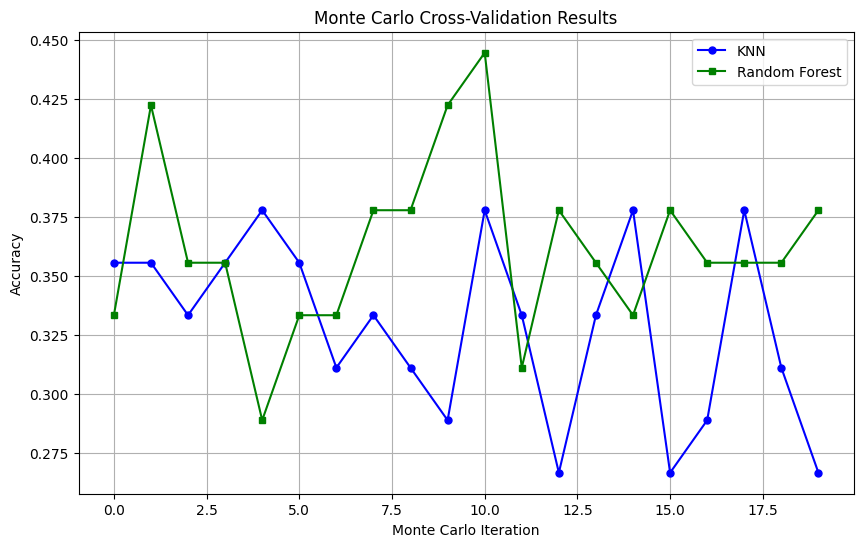

In [ ]:


knn_accuracies = knn_retention_results_from_learning['accuracies']
rf_accuracies = rf_retention_results_from_learning['accuracies']

plt.figure(figsize=(10, 6))

# Plot for RF for 20 monte Carlo Cross Validation 
plt.plot(knn_accuracies, label='KNN', color='blue', marker='o', linestyle='-', markersize=5)

# Plot for RF for 20 monte Carlo Cross Validation 
plt.plot(rf_accuracies, label='Random Forest', color='green', marker='s', linestyle='-', markersize=5)

plt.title('Monte Carlo Cross-Validation Results')
plt.xlabel('Monte Carlo Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

### Plotting Mean Accuracies of Classifiers (KNN vs. Random Forest)

This section of the code visualizes the comparison between KNN and Random Forest classifiers based on their mean accuracies for the retention session. The accuracy values are derived from the Monte Carlo cross-validation results. A bar plot is created to represent the mean accuracy for both classifiers, with text annotations displaying the exact values above each bar.


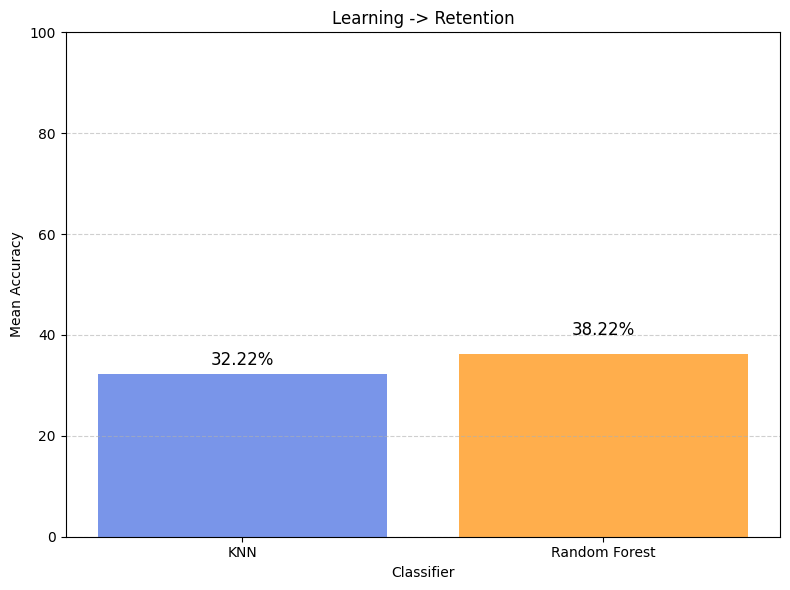

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mean accuracies from the results
knn_mean_accuracy = np.mean(knn_retention_results_from_learning['accuracies'])*100
rf_mean_accuracy = np.mean(rf_retention_results_from_learning['accuracies']) *100

classifiers = ['KNN', 'Random Forest']

# Mean accuracies of both modles 
mean_accuracies = [knn_mean_accuracy, rf_mean_accuracy]

plt.figure(figsize=(8, 6))
# Bar plot for the mean accuracies of both modles
plt.bar(classifiers, mean_accuracies, color=['royalblue', 'darkorange'], alpha=0.7)

plt.title('Learning -> Retention')
plt.xlabel('Classifier')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=12, color='black')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Evaluating KNN and Random Forest on Retention Sessions

These function calls evaluate the performance of **KNN** and **Random Forest** classifiers on **retention sessions**, using data from **learning sessions** for training.

## 📌 Breakdown of the Function Calls
- **Dataset:** `df_with_subsessions`
- **Feature Set:** `feature_columns`
- **Training Session:** `"retention"`
- **Testing Session:** `"Training"`
- **Monte Carlo Trials:** `20`
- **Session Type:** `"retention"` (filters relevant data)
- **Session Column:** `"session"` (identifies session types)

In [ ]:
knn_learning_results_from_retention = run_single_classifier_experiment_test(
    df_with_subsessions, feature_columns, classifier_type='knn',
    session_type='retention', session_column='session',
    n_monte_carlo=20, training_session='retention', testing_session='learning'
)

rf_learning_results_from_retention = run_single_classifier_experiment_test(
    df_with_subsessions, feature_columns, classifier_type='rf',
    session_type='retention', session_column='session',
    n_monte_carlo=20, training_session='retention', testing_session='learning'
)

Monte Carlo iteration 1/20 for knn
Monte Carlo iteration 2/20 for knn
Monte Carlo iteration 3/20 for knn
Monte Carlo iteration 4/20 for knn
Monte Carlo iteration 5/20 for knn
Monte Carlo iteration 6/20 for knn
Monte Carlo iteration 7/20 for knn
Monte Carlo iteration 8/20 for knn
Monte Carlo iteration 9/20 for knn
Monte Carlo iteration 10/20 for knn
Monte Carlo iteration 11/20 for knn
Monte Carlo iteration 12/20 for knn
Monte Carlo iteration 13/20 for knn
Monte Carlo iteration 14/20 for knn
Monte Carlo iteration 15/20 for knn
Monte Carlo iteration 16/20 for knn
Monte Carlo iteration 17/20 for knn
Monte Carlo iteration 18/20 for knn
Monte Carlo iteration 19/20 for knn
Monte Carlo iteration 20/20 for knn
Monte Carlo iteration 1/20 for rf
Monte Carlo iteration 2/20 for rf
Monte Carlo iteration 3/20 for rf
Monte Carlo iteration 4/20 for rf
Monte Carlo iteration 5/20 for rf
Monte Carlo iteration 6/20 for rf
Monte Carlo iteration 7/20 for rf
Monte Carlo iteration 8/20 for rf
Monte Carlo itera

## Monte Carlo Cross-Validation Results for KNN and Random Forest

This plot compares the **KNN** and **Random Forest** classifiers using the results from the 20 Monte Carlo cross-validation trials. Each classifier's accuracy is tracked across the iterations, providing insights into the model's performance stability.

### 📊 Plot Details:
- **KNN (Blue)**: Represented with circular markers (`o`).
- **Random Forest (Green)**: Represented with square markers (`s`).
- **X-axis**: Monte Carlo Iterations (1 to 20).
- **Y-axis**: Accuracy of the classifier.

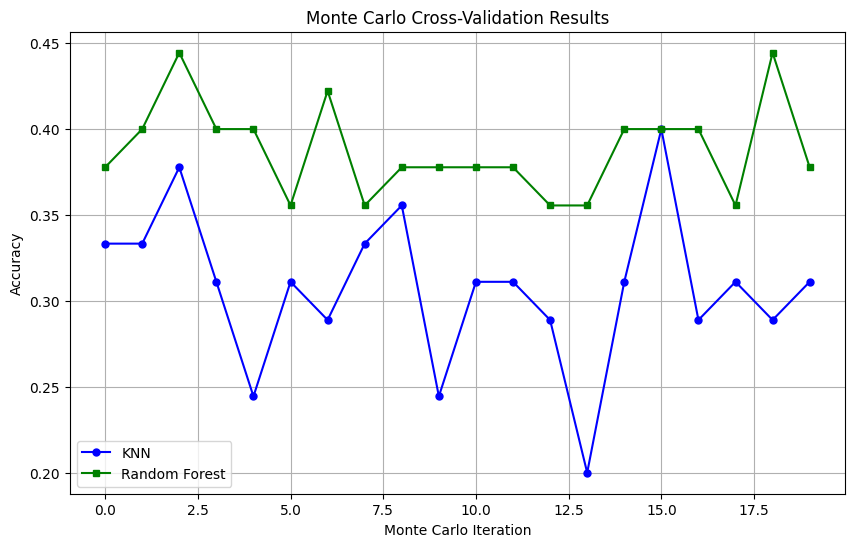

In [ ]:
import matplotlib.pyplot as plt

# accuracies from the results of each Models
knn_accuracies = knn_learning_results_from_retention['accuracies']
rf_accuracies = rf_learning_results_from_retention['accuracies']


plt.figure(figsize=(10, 6))
# Plot for KNN for 20 monte Carlo Cross Validation 
plt.plot(knn_accuracies, label='KNN', color='blue', marker='o', linestyle='-', markersize=5)
# Plot for RF for 20 monte Carlo Cross Validation 
plt.plot(rf_accuracies, label='Random Forest', color='green', marker='s', linestyle='-', markersize=5)

plt.title('Monte Carlo Cross-Validation Results')
plt.xlabel('Monte Carlo Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

### Plotting Mean Accuracies of Classifiers (KNN vs. Random Forest)

This section of the code visualizes the comparison between KNN and Random Forest classifiers based on their mean accuracies for the training session. The accuracy values are derived from the Monte Carlo cross-validation results. A bar plot is created to represent the mean accuracy for both classifiers, with text annotations displaying the exact values above each bar.


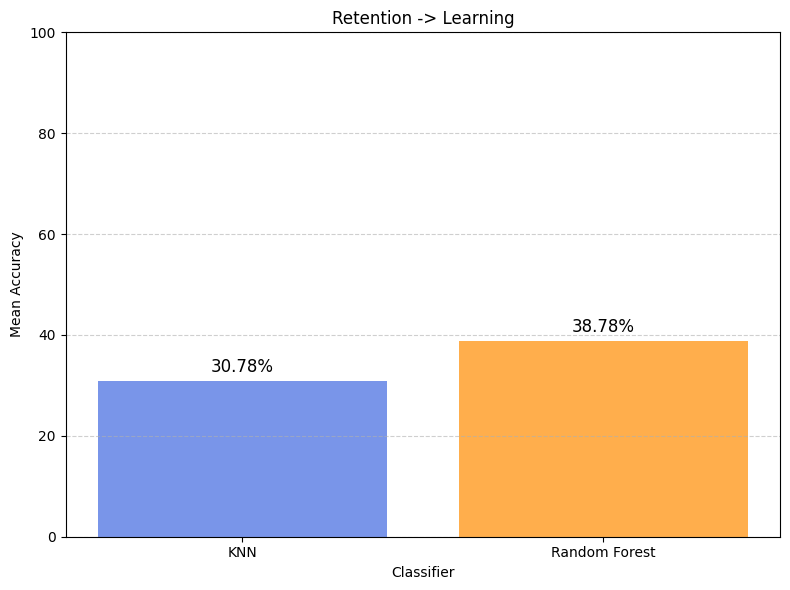

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# means of the accuracy of models 
knn_mean_accuracy = np.mean(knn_learning_results_from_retention['accuracies']) * 100
rf_mean_accuracy = np.mean(rf_learning_results_from_retention['accuracies']) * 100

# Model names 
classifiers = ['KNN', 'Random Forest']
mean_accuracies = [knn_mean_accuracy, rf_mean_accuracy]

# Set up the figure
plt.figure(figsize=(8, 6))

# Bar Plot Diagram 
bars = plt.bar(classifiers, mean_accuracies, color=['royalblue', 'darkorange'], alpha=0.7)

plt.title('Retention -> Learning')
plt.xlabel('Classifier')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 100)


for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=12, color='black')

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()